<a href="https://colab.research.google.com/github/vithushanms/deep-neural-network-fundamentals/blob/main/back%20propagation%20fundamentals/001_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration of backpropogation - part 01

## Intro

This project helps to understand the complexity of training neural networks by building an auto grad engine.

First of all the credit to this project goes to Andrej Karpathy as most of the examples here were prepared ontop of his lecture on [Neural Networks: Zero to Hero series](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2)  in youtube

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

## Grad

The deffinition: a gradiant explains how the impact of a small nudge in the input with regards to outcome of final mathematical functions

### Derivatives vs. Gradients: The Key Difference
You're right to be confused - they're closely related! Let me clarify the difference:

#### Derivative (One-Dimensional)
A derivative applies to a function with a single input variable:
For a function f(x), the derivative f'(x) tells you the rate of change at point x
It's a single number (a scalar)

Example: If f(x) = x², then f'(x) = 2x

#### Gradient (Multi-Dimensional)
A gradient applies to a function with multiple input variables:
For a function f(x, y, z), the gradient ∇f is a vector containing all partial derivatives
It has one component for each input variable: ∇f = [∂f/∂x, ∂f/∂y, ∂f/∂z]
It's a vector, not just a single number

Example: If f(x,y) = x² + y², then ∇f = [2x, 2y]

### Let's understand the derivative of $x^2$

Let's explore why the derivative of $x^2$ is $(2x)$. The derivative represents the rate of change of a function, and we'll derive this result step-by-step using the definition of the derivative, then explain it intuitively.

Using the Definition of the Derivative
The derivative of a function $f(x)$ at a point $(x)$ is defined as:
$f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}$

For $f(x) = x^2$, we need to compute:
$f'(x) = \lim_{h \to 0} \frac{(x + h)^2 - x^2}{h}$

Step 1: Expand $f(x+h)$

First, expand $(x+h)^2$. As we determined earlier:
$(x + h)^2 = x^2 + 2xh + h^2$

So:
$f(x + h) = (x + h)^2 = x^2 + 2xh + h^2$

Step 2: Substitute into the Limit
Now plug this into the derivative formula:
$f'(x) = \lim_{h \to 0} \frac{(x^2 + 2xh + h^2) - x^2}{h}$

Step 3: Simplify the Numerator
Subtract $x^2$ from $x^2 + 2xh + h^2$:
$x^2 + 2xh + h^2 - x^2 = 2xh + h^2$

The $x^2$ terms cancel out, leaving:
$f'(x) = \lim_{h \to 0} \frac{2xh + h^2}{h}$

Step 4: Factor and Simplify
Factor $(h)$ out of the numerator:
$2xh + h^2 = h(2x + h)$

So the expression becomes:
$f'(x) = \lim_{h \to 0} \frac{h(2x + h)}{h}$

Since $h \neq 0$ in the fraction (we're taking the limit as $(h)$ approaches 0, not equaling 0), we can cancel the $(h)$ terms:
$f'(x) = \lim_{h \to 0} (2x + h)$

Step 5: Evaluate the Limit
As $(h)$ approaches 0, $2x + h$ becomes $2x + 0 = 2x$:
$f'(x) = 2x$

Thus, the derivative of $x^2$ is $(2x)$.

In [6]:
def f(x):
  return 3*x**2 - 4*x + 5

In [7]:
f(10)

265

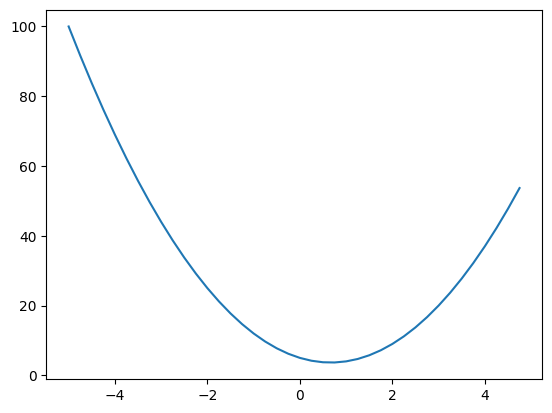

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
x = 3.000
h = 0.000000000000001
f(x + h)

20.00000000000001

As a limit
the function of a real variable
f
(
x
) is differentiable at a point
a of its domain, if its domain contains an open interval containing
a, and the limit

Limit(h -> 0) {(f(a+h) - f(a)) / h}


In [11]:
(f(x+h) - f(h)) / h

1.5000000000000014e+16

### Example 01

When h = 1, the difference between d1 and d2 is going to be -3 because the derivative of the function with respect to a is b, which equals -3.

Also, the slop is going to be - 3 irrespective of the value of h as it's a linear function.

In [18]:
h = 1

a = 1.0
b = -3.0
c = 10

d1 = a*b + c
a = a + h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 7.0
d2 4.0
slope -3.0


# Autograd Engine

Now let's build an autograd engine from the scratch. here to start with, we are using object representaion of values, which would alove us to store information such as previous node, next node, operations used throughout the mathematical operations, etc.

Eventually, we will visualize this to understand the contributions from inputs and intermediate states on the end result of a complex mathematical expression

### Class for a solo value node

In [56]:
class Value:
  def __init__(self, data, _children=(), _op=(), label = ''):
    self.data = data
    self.prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return Value(self.data + other.data, (self, other), '+')

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return Value(self.data * other.data, (self, other), 'x')
  
  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return Value(self.data - other.data, (self, other), '-')
  
  def __truediv__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return Value(self.data / other.data, (self, other), '/')
  

    

In [52]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

### Visualization of value nodes

In [53]:
def trace (root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Here we are trying to visualize the whole forward propogation (aka forward pass)

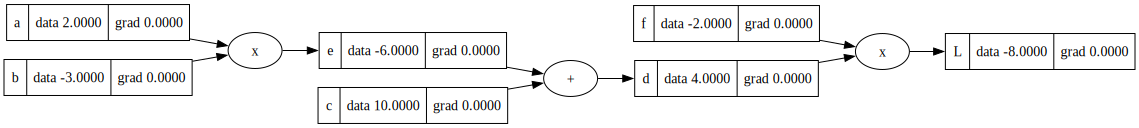

In [54]:
dot = draw_dot(L)
dot

Now, will connect the dots by bringing derivatives into the picture by manually calculating them (Manual Backpropogation)

In [73]:
# when direcrly adding a small diff h to L, we can figure out the derivative of L with respect to L by identifying the limit
h = 0.00000001

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'  
L1 = L


L2 = L1 + h

(L2 - L1) / h # This is going to be the derivative of L with respect to L which is 1

Value(data=0.999999993922529)

Any changes we make in L, will be directy propositional ot L

In [75]:
L.grad = 1

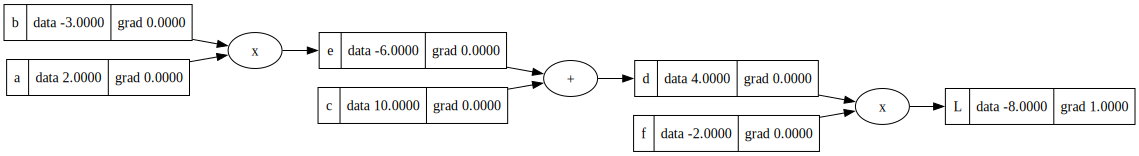

In [76]:
dot = draw_dot(L)
dot

Let's calculate the derivative of L with respect to f

$L = f \cdot d$

A small change $h$ on $f$ gives us:

$\frac{dL}{df} = \lim_{h \to 0} \frac{((f + h) \cdot d - f \cdot d)}{h}$
$= \lim_{h \to 0} \frac{fd + hd - fd}{h}$
$= \lim_{h \to 0} \frac{hd}{h}$
$= d$

So the gradient of L with respect to f is d, and vice versa.

In [80]:
d.grad = -2.0
f.grad = 4.0

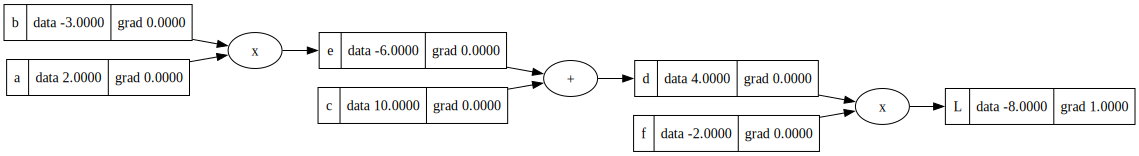

In [81]:
draw_dot(L)

The derivative of L with respect to d is e

dL/de = dL/dd * dd/de

d = e + c
derivative of d with respect to e
limit h -> 0 (e + h + c - e - c) / h
= limit h -> 0 h / h
= 1

here
dd/de = 1
as well as dd/dc = 1

proof </br>
((e+h) + c) - (e + c) / h </br>
= e + h + c - e - c /h </br>
= 1


In [29]:
e.grad = 1
c.grad = 1
b.grad = 2
a.grad = -3

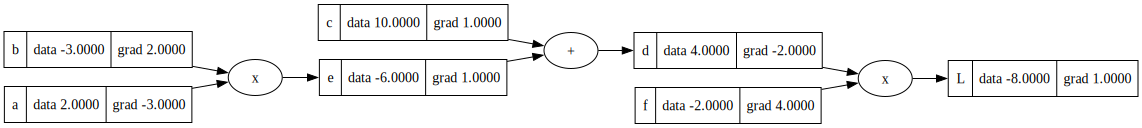

In [30]:
draw_dot(L)

Now will use the chain rule to understand the imapct of very first inputs on the end results.

dz/dx = dz/dy * dy/dx </br>

dL/de = dL/dd * dd/de </br>
dL/de = -2 * 1 = -2

dL/db = dL/de * de/db </br>
dL/de = 2 * 2 = -4

what this means is if we nudge b by 1, the result will change by -6.
      

In [31]:
h = 1

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L1 = L

a = Value(2.0, label='a')
b = Value(-3.0 + h, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L2 = L

print(f"L1 value {L1}")
print(f"L2 value {L2}")

L1 value Value(data=-8.0)
L2 value Value(data=-12.0)


We can also proof this by

In [32]:
(L2.data - L1.data) / h

-4.0